<a href="https://colab.research.google.com/github/plaban1981/Hugging_Face_transformers_topics/blob/main/Falcon_Coder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! nvidia-smi

Thu Jun 22 14:35:23 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install -qU  git+https://github.com/huggingface/transformers.git
!pip install -qU  git+https://github.com/huggingface/accelerate.git
!pip install -qU  git+https://github.com/huggingface/peft.git
!pip install -q datasets
!pip install -qU bitsandbytes
!pip install -qU einops

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 83.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 82.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.6/485.6 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 25.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━

## Import Necessary Packages - using QloRA

In [3]:
import torch
from peft import PeftModel, PeftConfig
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, AutoTokenizer, GenerationConfig


===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
bin /usr/local/lib/python3.10/dist-packages/bitsandbytes/libbitsandbytes_cuda118.so
CUDA_SETUP: WARNING! libcudart.so not found in any environmental path. Searching in backup paths...
CUDA SETUP: CUDA runtime path found: /usr/local/cuda/lib64/libcudart.so
CUDA SETUP: Highest compute capability among GPUs detected: 7.5
CUDA SETUP: Detected CUDA version 118
CUDA SETUP: Loading binary /usr/local/lib/python3.10/dist-packages/bitsandbytes/libbitsandbytes_cuda118.so...


/usr/local/lib/python3.10/dist-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: /usr/lib64-nvidia did not contain ['libcudart.so', 'libcudart.so.11.0', 'libcudart.so.12.0'] as expected! Searching further paths...
  warn(msg)
/usr/local/lib/python3.10/dist-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('/sys/fs/cgroup/memory.events /var/colab/cgroup/jupyter-children/memory.events')}
  warn(msg)
/usr/local/lib/python3.10/dist-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('8013'), PosixPath('//172.28.0.1'), PosixPath('http')}
  warn(msg)
/usr/local/lib/python3.10/dist-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('--logtostderr --listen_host=172.28.0.12 --

## Instantiate PEFT Model

In [4]:
peft_model_id = "mrm8488/falcon-7b-ft-codeAlpaca_20k-v2" # adapter
config = PeftConfig.from_pretrained(peft_model_id)
model = AutoModelForCausalLM.from_pretrained(config.base_model_name_or_path,
                                             return_dict=True,
                                             load_in_8bit=True,
                                             device_map={"":0},
                                             trust_remote_code=True)
tokenizer = AutoTokenizer.from_pretrained(peft_model_id)

A new version of the following files was downloaded from https://huggingface.co/tiiuae/falcon-7b:
- configuration_RW.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


A new version of the following files was downloaded from https://huggingface.co/tiiuae/falcon-7b:
- modelling_RW.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

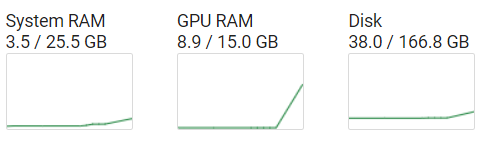

In [5]:
model = PeftModel.from_pretrained(model, peft_model_id)
model.eval()

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): RWForCausalLM(
      (transformer): RWModel(
        (word_embeddings): Embedding(65024, 4544)
        (h): ModuleList(
          (0-31): 32 x DecoderLayer(
            (input_layernorm): LayerNorm((4544,), eps=1e-05, elementwise_affine=True)
            (self_attention): Attention(
              (maybe_rotary): RotaryEmbedding()
              (query_key_value): Linear8bitLt(
                in_features=4544, out_features=4672, bias=False
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4544, out_features=64, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=64, out_features=4672, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): Paramete

## Release unused memory

In [6]:
import gc
import torch
gc.collect()
#
torch.cuda.empty_cache()

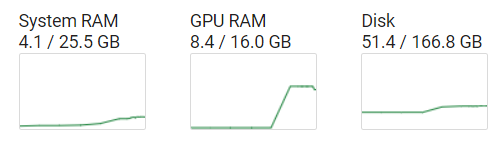

## Model Inference Function

In [10]:
def generate(
        instruction,
        max_new_tokens=128,
        temperature=0.1,
        top_p=0.75,
        top_k=40,
        num_beams=4,
        **kwargs
):
    prompt = instruction + "\n### Solution:\n"
    print(prompt)
    inputs = tokenizer(prompt, return_tensors="pt")
    input_ids = inputs["input_ids"].to("cuda")
    attention_mask = inputs["attention_mask"].to("cuda")
    generation_config = GenerationConfig(
        temperature=temperature,
        top_p=top_p,
        top_k=top_k,
        num_beams=num_beams,
        **kwargs,
    )
    with torch.no_grad():
        generation_output = model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            generation_config=generation_config,
            return_dict_in_generate=True,
            output_scores=True,
            max_new_tokens=max_new_tokens,
            early_stopping=True
        )
    s = generation_output.sequences[0]
    output = tokenizer.decode(s)
    return output.split("### Solution:")[1].lstrip("\n")

In [11]:
def release_memory():
  gc.collect()
  #
  torch.cuda.empty_cache()

## Test

In [7]:
instruction = "Design a class for representing a person in Python."
#
solution = generate(instruction)
print(solution)
#


Design a class for representing a person in Python.
### Solution:

class Person:
    def __init__(self, name, age, gender):
        self.name = name
        self.age = age
        self.gender = gender

    def get_name(self):
        return self.name

    def get_age(self):
        return self.age

    def get_gender(self):
        return self.gender

    def set_name(self, name):
        self.name = name

    def set_age(self, age):
        self.age = age

    def set_gender(self, gender):
        self.gender = gender

    def __str__(self):
        return f"Name: {self.name}, Age: {self.age}, Gender: {self.gender}"

person = Person("John", 30, "Male")
print(person) # Name: John, Age: 30, Gender: Male
person.set_name("Jane")
person.set_age(20)
person.set_gender("Female")
print(person) # Name: Jane, Age: 20, Gender: Female
person.set_name("John")
person


In [11]:
instruction = "Write a function that takes list of list.Name your function as flatten.It should take a single parameter and return a list which will not have sublists."
#
solution = generate(instruction)
print(solution)
#


Write a function that takes list of list.Name your function as flatten.It should take a single parameter and return a list which will not have sublists.
### Solution:

def flatten(lst):
    result = []
    for item in lst:
        if isinstance(item, list):
            result.extend(flatten(item))
        else:
            result.append(item)
    return result

print(flatten([[1,2,3],[4,5,6],[7,8,9]]))
# Output: [[1, 2, 3], [4, 5, 6], [7, 8, 9]]

Output: [[1, 2, 3], 


In [ ]:
instruction = "Design a class for representing a person in Java."
#
solution = generate(instruction)
print(solution)

Design a class for representing a person in Java.
### Solution:

public class Person {
    private String firstName;
    private String lastName;
    private int age;

    public Person(String firstName, String lastName, int age) {
        this.firstName = firstName;
        this.lastName = lastName;
        this.age = age;
    }

    public String getFirstName() {
        return firstName;
    }

    public String getLastName() {
        return lastName;
    }

    public int getAge() {
        return age;
    }

    public void setFirstName(String firstName) {


In [ ]:
instruction = "How to generate tokens using NLP in python."
#
solution = generate(instruction)
print(solution)

How to generate tokens using NLP in python.
### Solution:

"""
How to generate tokens using NLP in python.
"""

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import wordnet

def tokenize(sentence):
    tokens = word_tokenize(sentence)
    tokens = [token.lower() for token in tokens]
    tokens = [token for token in tokens if token not in stopwords.words('english')]
    tokens = [token for token in tokens if token not


In [ ]:
instruction = "How to use Falcon7B model for inference using python?"
#
solution = generate(instruction)
print(solution)

How to use Falcon7B model for inference using python?
### Solution:

import falcon7b
model = falcon7b.Falcon7B()
model.predict([[1,2,3], [4,5,6], [7,8,9]])
print(model.predict([[1,2,3], [4,5,6], [7,8,9]]))
# Output: [1, 2, 3]
# Output: [4, 5, 6]
# Output: [7, 8, 9]
# Output: [


* we cannot solve complex programs using this

## mrm8488/falcoder-7b full version

In [3]:
! nvidia-smi

Thu Jun 22 13:37:06 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    24W / 300W |      0MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
!pip install -qU  git+https://github.com/huggingface/transformers.git
!pip install -qU  git+https://github.com/huggingface/accelerate.git
!pip install -qU einops

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 100.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 80.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 4.2 MB/s eta 0:00:00


## Download the model

In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, AutoTokenizer

model_id = "mrm8488/falcoder-7b"

tokenizer = AutoTokenizer.from_pretrained(model_id)

model = AutoModelForCausalLM.from_pretrained(model_id,trust_remote_code=True).to("cuda")



Loading mrm8488/falcoder-7b requires to execute some code in that repo, you can inspect the content of the repository at https://hf.co/mrm8488/falcoder-7b. You can dismiss this prompt by passing `trust_remote_code=True`.
Do you accept? [y/N] y


A new version of the following files was downloaded from https://huggingface.co/tiiuae/falcon-7b:
- configuration_RW.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


Loading mrm8488/falcoder-7b requires to execute some code in that repo, you can inspect the content of the repository at https://hf.co/mrm8488/falcoder-7b. You can dismiss this prompt by passing `trust_remote_code=True`.
Do you accept? [y/N] y


A new version of the following files was downloaded from https://huggingface.co/tiiuae/falcon-7b:
- modelling_RW.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


## Release unused memory

In [6]:
import gc
import torch
gc.collect()
#
torch.cuda.empty_cache()

## Model Inference

In [ ]:
def generate(
        instruction,
        max_new_tokens=128,
        temperature=0.1,
        top_p=0.75,
        top_k=40,
        num_beams=4,
        **kwargs
):
    prompt = instruction + "\n### Solution:\n"
    print(prompt)
    inputs = tokenizer(prompt, return_tensors="pt")
    input_ids = inputs["input_ids"].to("cuda")
    attention_mask = inputs["attention_mask"].to("cuda")
    generation_config = GenerationConfig(
        temperature=temperature,
        top_p=top_p,
        top_k=top_k,
        num_beams=num_beams,
        **kwargs,
    )
    with torch.no_grad():
        generation_output = model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            generation_config=generation_config,
            return_dict_in_generate=True,
            output_scores=True,
            max_new_tokens=max_new_tokens,
            early_stopping=True
        )
    s = generation_output.sequences[0]
    output = tokenizer.decode(s)
    return output.split("### Solution:")[1].lstrip("\n")




## Test the model for inference on an instruction

In [ ]:
instruction = "Design a class for representing a person in Python."
print(generate(instruction))